In [1]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [3]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in pyspi SPI info 
pyspi_info = pd.read_csv("../feature_extraction/pyspi/pyspi_SPI_info.csv")

### HCP100 ###
HCP100_Pearson_HoFC = (pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
                        .merge(pyspi_info, on="SPI", how="left")
                        .query("SPI=='cov_EmpiricalCovariance' & base_region_to==base_region_from")
                        .dropna(subset=['value'])
                        .rename(columns={"Subject": "Sample_ID", "base_region_to": "base_region"})[['Sample_ID', 'base_region', 'value']]
                        .groupby(['Sample_ID', 'base_region'])['value']
                        .mean()
                        .reset_index()
                        .drop_duplicates()
                        .assign(Diagnosis = "HCP100")
                        )

### UCLA CNP ###
UCLA_CNP_metadata = pd.read_feather(f"{data_path}/time_series_features/UCLA_CNP_sample_metadata_filtered.feather")
UCLA_CNP_Pearson_HoFC = (pd.read_csv(f"{data_path}/time_series_features/UCLA_CNP_Pearson_HoFC.csv")
                         .merge(UCLA_CNP_metadata, on="Sample_ID", how="left"))

UCLA_CNP_Pearson_HoFC_mean = (UCLA_CNP_Pearson_HoFC
                              .groupby(['Diagnosis', 'base_region'])['value']
                                .mean()
                                .reset_index()
                                .rename(columns={"value": "Mean_Pearson_R"})
)

All_Pearson_HoFC = pd.concat([HCP100_Pearson_HoFC, UCLA_CNP_Pearson_HoFC]).assign(SPI = "cov_EmpiricalCovariance")
All_Pearson_HoFC_mean = All_Pearson_HoFC.groupby(["Diagnosis", "base_region"])['value'].mean().reset_index().rename(columns={"value": "Mean_Pearson_R"})

Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning messages:
1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  side  region label              roi   Diagnosis base_region 
  <chr> <chr> <chr> <chr> <chr>  <glue>             <chr> <chr>     <chr>       
1 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Accumbens-area  <NA>  Control   Accumbens-a…
2 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Amygdala        <NA>  Control   Amygdala    
3 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Caudate         <NA>  Control   Caudate     
4 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Hippocampus     <NA>  Control   Hippocamp

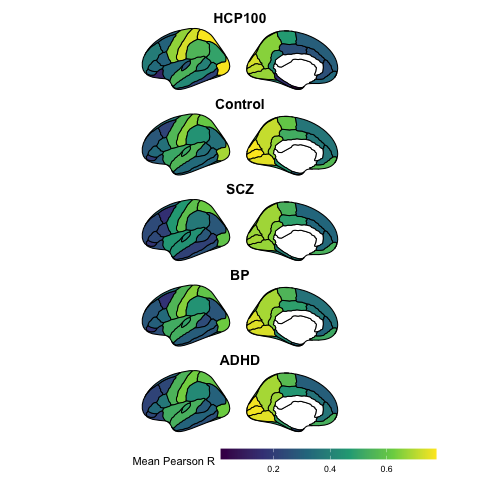

In [7]:
%%R -i All_Pearson_HoFC_mean

min_Pearson_R = min(All_Pearson_HoFC_mean$Mean_Pearson_R)
max_Pearson_R = max(All_Pearson_HoFC_mean$Mean_Pearson_R)

### Pearson FC in brain ###
dx_plot_list <- list() 
for (dx in c("HCP100", "Control", "SCZ", "BP", "ADHD")) {
    dx_plot <- All_Pearson_HoFC_mean %>%
      filter(Diagnosis==dx) %>%
      mutate(label = glue("lh_{base_region}")) %>%
      left_join(., as_tibble(dk)) %>%
      ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
            position = "stacked", colour = "black", hemisphere="left",
            linewidth=0.5) +
      theme_void() +
      ggtitle(dx) +
      labs(fill = "Mean Pearson R") +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
      scale_fill_viridis_c(na.value = "white", limits=c(min_Pearson_R, max_Pearson_R))
    dx_plot_list[[dx]] <- dx_plot
}

wrap_plots(dx_plot_list, ncol=1) +
       plot_layout(guides = "collect", axis_titles = "collect") & 
       theme(legend.position = 'bottom')

# ggsave("../plots/neuropsych_cases/UCLA_CNP_Pearson_HoFC_mean_brains.svg", width=4, height=8, dpi=300, units='in')

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The dot-dot notation (`..r.label..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



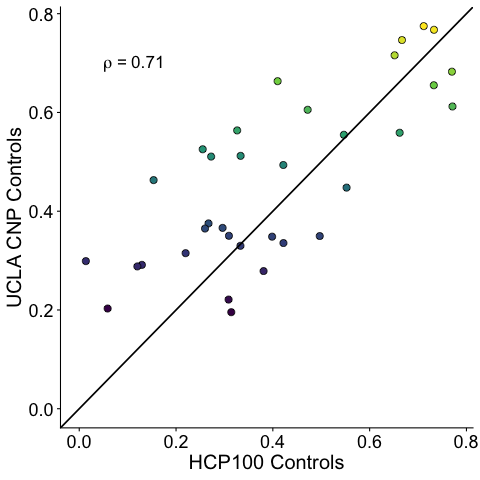

In [9]:
%%R -i All_Pearson_HoFC_mean 

## Is the mean Pearson-based HoFC comparable between controls in HCP100 vs UCLA CNP?
All_Pearson_HoFC_mean %>%
    filter(Diagnosis %in% c("HCP100", "Control")) %>% 
    pivot_wider(names_from="Diagnosis", values_from="Mean_Pearson_R") %>%
    filter(!is.na(HCP100)) %>%ggplot(data=., mapping=aes(x=HCP100, y=Control, fill=Control)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c() +
    xlab("HCP100 Controls") +
    ylab("UCLA CNP Controls") +
    # geom_smooth(method="lm", se=FALSE, color='black', linewidth=0.8) +
    geom_abline(intercept=0, slope=1, color='black', linewidth=0.8) +
    scale_x_continuous(limits=c(0, max_Pearson_R)) +
    scale_y_continuous(limits=c(0, max_Pearson_R)) +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", aes(label=..r.label..), size=6, label.x=0.05, label.y=0.7) +
    theme(strip.background = element_blank(),
            strip.text.x = element_text(face='bold', size=18),
            axis.title = element_text(size=20),
            axis.text = element_text(size=18),
          legend.position = "none")
# ggsave("../plots/neuropsych_cases/Control_HCP100_vs_UCLA_CNP_Pearson_HoFC.svg", width=3.25, height=3, dpi=300, units='in')

## How do Pearson-based HoFC values differ between Controls vs. SCZ, BP, and ADHD?

In [19]:
%%R -i All_Pearson_HoFC_mean 

slopes <- All_Pearson_HoFC_mean %>% 
    filter(Diagnosis != "HCP100") %>%
    pivot_wider(names_from="Diagnosis", values_from="Mean_Pearson_R") %>%
    pivot_longer(cols=c(-base_region, -Control), names_to="Diagnosis", values_to="Mean_Pearson_R") %>%
    mutate(Diagnosis = factor(Diagnosis, levels=c("SCZ", "BP", "ADHD"))) %>%
    group_by(Diagnosis) %>% 
       do({
       fit <- lm(Mean_Pearson_R ~ Control, data = .)
       data.frame(slope = coef(fit)[["Control"]])
       })

print(slopes)

# A tibble: 3 × 2
# Groups:   Diagnosis [3]
  Diagnosis slope
  <fct>     <dbl>
1 SCZ       0.906
2 BP        0.974
3 ADHD      1.02 


In [20]:
%%R -i All_Pearson_HoFC_mean 

min_Pearson_R = min(All_Pearson_HoFC_mean$Mean_Pearson_R)
max_Pearson_R = max(All_Pearson_HoFC_mean$Mean_Pearson_R)

All_Pearson_HoFC_mean %>% 
    filter(Diagnosis != "HCP100") %>%
    pivot_wider(names_from="Diagnosis", values_from="Mean_Pearson_R") %>%
    pivot_longer(cols=c(-base_region, -Control), names_to="Diagnosis", values_to="Mean_Pearson_R") %>%
    mutate(Diagnosis = factor(Diagnosis, levels=c("SCZ", "BP", "ADHD"))) %>%
    ggplot(data=., mapping=aes(x=Control, y=Mean_Pearson_R, fill=Control)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c() +
    xlab("Mean Pearson HoFC in Diagnostic Group") +
    ylab("Mean Pearson HoFC in Control Group") +
    facet_wrap(Diagnosis ~ ., scales="free", ncol=1) +
    geom_abline(intercept=0, slope=1, color='black', linewidth=0.8) +
    geom_smooth(method="lm", se=FALSE, color='red', linewidth=0.8) +
    # Print slope of regression line
    scale_x_continuous(limits=c(0, max_Pearson_R)) +
    scale_y_continuous(limits=c(0, max_Pearson_R)) +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", aes(label=..r.label..), size=6, label.x=0.05, label.y=0.7) +
    theme(strip.background = element_blank(),
            strip.text.x = element_text(face='bold', size=18),
            axis.title = element_text(size=20),
            axis.text = element_text(size=18),
          legend.position = "none")

# ggsave("../plots/neuropsych_cases/UCLA_CNP_Pearson_HoFC_dx_vs_control_scatters.svg", width=3, height=8, dpi=300, units='in')

`geom_smooth()` using formula = 'y ~ x'


In addition: Warning messages:
1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
4: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping

In [4]:
# Subtract mean Pearson R from ADHD, BP, or SCZ vs. Control
dx_HoFC_diffs_from_controls = (UCLA_CNP_Pearson_HoFC_mean
 .pivot(index='base_region', columns='Diagnosis', values='Mean_Pearson_R')
 .reset_index()
 .melt(id_vars=['base_region', 'Control'], var_name='Diagnosis', value_name='Mean_Pearson_R')
 .assign(DX_minus_Control = lambda x: x['Mean_Pearson_R'] - x['Control'])
 .drop_duplicates(subset=['base_region', 'Diagnosis', 'DX_minus_Control'])
 [['base_region', 'Diagnosis', 'DX_minus_Control']]
)

dx_HoFC_diffs_from_controls

,base_region,Diagnosis,DX_minus_Control
0,Accumbens-area,ADHD,0.012226
1,Amygdala,ADHD,-0.019831
2,Caudate,ADHD,-0.039089
3,Hippocampus,ADHD,-0.015103
4,Pallidum,ADHD,-0.009185
...,...,...,...
118,superiorparietal,SCZ,0.007352
119,superiortemporal,SCZ,-0.108798
120,supramarginal,SCZ,-0.072437
121,temporalpole,SCZ,0.112878


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning messages:
1: Some data not merged properly. Check for naming errors in data:
  atlas type  hemi  side  region label              roi   base_region  Diagnosis
  <chr> <chr> <chr> <chr> <chr>  <glue>             <chr> <chr>        <chr>    
1 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Accumbens-area  <NA>  Accumbens-a… ADHD     
2 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Amygdala        <NA>  Amygdala     ADHD     
3 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Caudate         <NA>  Caudate      ADHD     
4 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Hippocampus     <NA>  Hippocampus  ADHD     
5 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Pallidum        <NA>  Pallidum     ADHD     
6 <NA>  <NA>  <NA>  <NA>  <NA>   lh_Putamen         <NA>  Putamen      ADHD     
7 

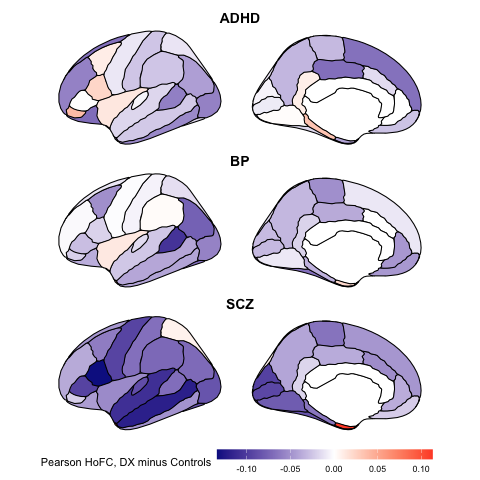

In [12]:
%%R -i dx_HoFC_diffs_from_controls

min_diff = min(dx_HoFC_diffs_from_controls$DX_minus_Control)
max_diff = max(dx_HoFC_diffs_from_controls$DX_minus_Control)

### Pearson FC in brain ###
dx_plot_list <- list() 
for (dx in unique(dx_HoFC_diffs_from_controls$Diagnosis)) {
    dx_plot <- dx_HoFC_diffs_from_controls %>%
      filter(Diagnosis==dx) %>%
      mutate(label = glue("lh_{base_region}")) %>%
      left_join(., as_tibble(dk)) %>%
      ggseg(atlas = dk, mapping = aes(fill = DX_minus_Control),
            position = "stacked", colour = "black", hemisphere="left",
            linewidth=0.5) +
      theme_void() +
      ggtitle(dx) +
      labs(fill = "Pearson HoFC, DX minus Controls") +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradient2(low = "#0F1F91", mid = "white", high = "red", midpoint=0, 
                           limits=c(min_diff, max_diff), na.value = "white")
    dx_plot_list[[dx]] <- dx_plot
}

wrap_plots(dx_plot_list, ncol=1) +
       plot_layout(guides = "collect", axis_titles = "collect") & 
       theme(legend.position = 'bottom')

# ggsave("../plots/neuropsych_cases/UCLA_CNP_Pearson_HoFC_dx_vs_control_brains.svg", width=4, height=6, dpi=300, units='in')

## Do neuropsychiatric disorder patients also exhibit left--right asymmetries?

In [ ]:
HCP100_DI_subtract_diffs = (HCP100_DI_gaussian_HoFC
 .groupby(['Sample_ID', 'base_region'])
    .apply(lambda x: x.value[x.hemi_from=='right'].values - x.value[x.hemi_from=='left'].values)
    .reset_index()
    .rename(columns={0: 'RL_minus_LR'})
    # Flatten the list of arrays
    .explode('RL_minus_LR')
    .assign(Diagnosis='HCP100')
    )

UCLA_CNP_region_DI_subtract_diffs = (UCLA_CNP_DI_gaussian_HoFC
 .groupby(['Sample_ID', 'Diagnosis', 'base_region'])
 .apply(lambda x: x.value[x.hemi_from=='R'].values - x.value[x.hemi_from=='L'].values)
 .reset_index()
 .rename(columns={0: 'RL_minus_LR'})
 # Flatten the list of arrays
 .explode('RL_minus_LR')
)

all_region_DI_subtract_diffs = pd.concat([UCLA_CNP_region_DI_subtract_diffs, HCP100_DI_subtract_diffs])
all_region_DI_subtract_diffs.head()

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_89409/1785798719.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  HCP100_DI_subtract_diffs = (HCP100_DI_gaussian_HoFC
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_89409/1785798719.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  UCLA_CNP_region_DI_subtract_diffs = (UCLA_CNP_DI_gaussian_HoFC


,Sample_ID,Diagnosis,base_region,RL_minus_LR
0,sub-10159,Control,Accumbens-area,0.019182
1,sub-10159,Control,Amygdala,0.046294
2,sub-10159,Control,Caudate,-0.027662
3,sub-10159,Control,Hippocampus,0.090377
4,sub-10159,Control,Pallidum,-0.066642


In [ ]:
%%R -i all_region_DI_subtract_diffs -o region_order_DI_asym

# What is the difference in DI by brain region?
all_region_DI_subtract_diffs <- all_region_DI_subtract_diffs %>%
  mutate(RL_minus_LR = as.numeric(RL_minus_LR)) %>%
  group_by(base_region, Diagnosis) %>%
  mutate(mean_RL_minus_LR = mean(RL_minus_LR, na.rm=TRUE),
         sd_RL_minus_LR = sd(RL_minus_LR, na.rm=TRUE)) %>%
  ungroup() %>% 
  mutate(Diagnosis = factor(Diagnosis, levels=c("HCP100", "Control", "SCZ", "BP", 'ADHD')))

asym_min = min(all_region_DI_subtract_diffs$mean_RL_minus_LR)
asym_max = max(all_region_DI_subtract_diffs$mean_RL_minus_LR)
  
region_order_DI_asym <- all_region_DI_subtract_diffs %>%
  filter(Diagnosis == "HCP100") %>%
  mutate(base_region = fct_reorder(base_region, mean_RL_minus_LR, .fun=median))  %>% 
  arrange(base_region) %>% 
  distinct(base_region) %>% 
  pull(base_region)

dx_plots <- list()

for (this_dx in c("HCP100", "Control", "SCZ", "BP", 'ADHD')) {
  dx_plot <- all_region_DI_subtract_diffs %>%
    mutate(base_region = factor(base_region, levels=region_order_DI_asym)) %>%
    filter(!is.na(base_region) & Diagnosis == this_dx) %>%
    ggplot(data=., mapping=aes(x=base_region, y=RL_minus_LR, fill=mean_RL_minus_LR)) +
    geom_violinhalf(scale="width", color="black", position = position_nudge(x = 0.3), width=1)  +
    geom_point(aes(color = mean_RL_minus_LR), position = position_jitter(width = 0.075, height=0),
                            size = 1.75, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.5, linewidth=0.3, 
            show.legend=FALSE, position = position_nudge(x = 0.55)) +
    scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90", midpoint=0, limits=c(asym_min, asym_max)) +
    scale_color_gradient2(high="#f47599", low="#5dc636", mid="gray90", midpoint=0, limits=c(asym_min, asym_max)) +
    ggtitle(this_dx) +
    geom_hline(yintercept=0, linetype=2) +
    theme(legend.position = "none",
          plot.title = element_text(hjust=0.5, face='bold')) +
    coord_flip() +
    ylab("R\u2192L minus L\u2192R DI") +
    xlab("Cortical region")

  dx_plots[[this_dx]] <- dx_plot
}

# Remove y-axis elements except for the first plot
dx_plots[-1] <- lapply(dx_plots[-1], function(p) p + theme(axis.title.y = element_blank(), 
                                                         axis.text.y = element_blank(), 
                                                         axis.ticks.y = element_blank()))

# Combine with patchwork
wrap_plots(dx_plots) + plot_layout(nrow = 1, guides = "collect", axis_titles = "collect") & 
  theme(legend.position = 'bottom')

# ggsave("../plots/neuropsych_cases/HCP100_vs_UCLA_CNP_DI_gaussian_LR_asym_rainclouds.svg", width=8, height=10, dpi=300, units="in")

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Sample_ID". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "RL_minus_LR". Fall back to string conversion. The error is: <class 'nump

In [ ]:
all_region_DI_subtract_diffs_mean = (all_region_DI_subtract_diffs[['base_region', 'RL_minus_LR', 'Diagnosis']]
                                 .drop_duplicates()
                                 .groupby(['base_region', 'Diagnosis'])['RL_minus_LR']
                                 .mean()
                                 .reset_index()
                                 .rename(columns={"RL_minus_LR": "Mean_RL_minus_LR_DI"})
                                 # Assign Mean_RL_minus_LR_DI as numeric
                                .assign(Mean_RL_minus_LR_DI = lambda x: pd.to_numeric(x['Mean_RL_minus_LR_DI']))
)

base_region             object
Diagnosis               object
Mean_RL_minus_LR_DI    float64
dtype: object

In [ ]:
%%R -i all_region_DI_subtract_diffs_mean

asym_min = min(all_region_DI_subtract_diffs_mean$Mean_RL_minus_LR_DI, na.rm=TRUE)
asym_max = max(all_region_DI_subtract_diffs_mean$Mean_RL_minus_LR_DI, na.rm=TRUE)

# Plot in the brain
plot_list <- list()
for (this_dx in c("HCP100", "Control", "SCZ", "BP", 'ADHD')) {
      p <- all_region_DI_subtract_diffs_mean %>%
            filter(!is.na(base_region) & Diagnosis == this_dx) %>%
            distinct(base_region, Mean_RL_minus_LR_DI, Diagnosis) %>%
            mutate(label = glue("lh_{base_region}"),
                   Mean_RL_minus_LR_DI = as.numeric(Mean_RL_minus_LR_DI)) %>%
            left_join(., as_tibble(dk)) %>%
            filter(!is.na(region)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Mean_RL_minus_LR_DI),
                  position = "stacked", colour = "gray20", hemisphere="left") +
            theme_void() +
            scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90", na.value="white", 
                                 midpoint=0, limits=c(asym_min, asym_max)) +
            labs(fill = "Mean RL minus LR DI") +
            theme(plot.title = element_blank(),
                  legend.position = "bottom")

      plot_list[[this_dx]] <- p
}

wrap_plots(plot_list, ncol=1) +
  plot_layout(guides = "collect", axis_titles = "collect") & 
  theme(legend.position = 'bottom')
ggsave("../plots/neuropsych_cases/HCP100_vs_UCLA_CNP_DI_RL_minus_LR_brain.svg", width=4, height=8, dpi=300, units='in')

Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
